In [ ]:
# 인용 : https://www.kaggle.com/asindico/customer-segments-with-pca
# 참조 : https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset

  
+ **목적** : 구매이력 기반, 유의미한 그룹 분류
+ **방법** : k-means (PCA를 통한 차원축소 후)
+ **대상** : 19.09 구매회원 기준  
---  
+ **결론**
  + 임직원/일반회원간의 구매패턴 차이 발생
  + 양 그룹 모두, 3그룹으로 분류 가능함
    + 임직원 : 아침식사 / 음료&제빵 / 주스류 구매
    + 일반회원 : 라떼 S 사이즈 선호 / 라떼 S 사이즈 선호 / 룽고선호 
  

In [30]:
#######
# import
###

import os
os.environ['NLS_LANG'] = '.UTF8'
import cx_Oracle as oci
import pandas as pd

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [31]:
#######
#1. 자료추출(Oracel SQL)
###

## DB 접속
conn = oci.connect('****************************************************')

## query 실행( =자료 추출)
df_all = pd.read_sql("select S.stor_cd || S.pos_no || S.bill_no as order_no, S.Item_cd, S.sale_qty " + 
                     ", S.CUST_id, c.emp_no, 2019-substr(c.birth_dt,1,4) as age " + 
                     ", C.lvl_cd, REGEXP_substr(trim(C.addr1), '[^ ]+' ) as region "
                     "from sale_dt S, item I, c_cust C " +
                     "where S.sale_dt between '20190901' and '20190930' " +
                     "and S.item_cd = I.item_cd(+) " +
                     "and cust_stat <> 9 " +
                     "and C.cust_id = S.cust_id " +
                     "and c.unfy_mmb_no is not null "+
                     "and S.t_seq = 0 " +
                     "and S.CUST_id is not null "
                      , con = conn )

## DB 접속종료
conn.close()

In [32]:
### 자료확인
df_all.head(3)

,ORDER_NO,ITEM_CD,SALE_QTY,CUST_ID,EMP_NO,AGE,LVL_CD,REGION
0,20000430100046,170054,1,ssj927,1308015,30,103,서울특별시
1,20000080100034,179797,1,ssj927,1308015,30,103,서울특별시
2,20001040200047,271011,1,ssj927,1308015,30,103,서울특별시


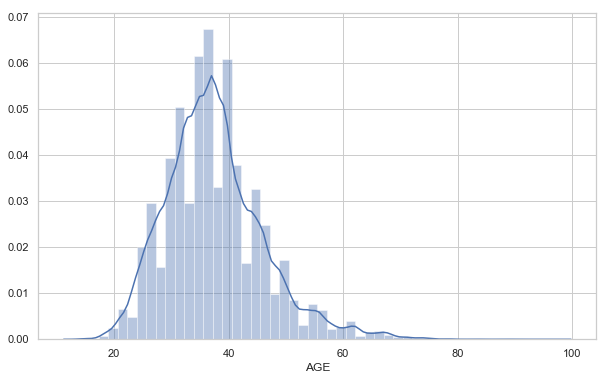

In [37]:
# 회원분포 확인 : 연령

df_age = df_all[df_all['AGE'] < 99 ]

fig = plt.figure(figsize=(10,6))
sns.distplot(df_age['AGE'].dropna())
plt.show()

In [38]:
import cufflinks
from plotly.offline import iplot
cufflinks.go_offline()

df_age.groupby(['CUST_ID']).max()['AGE'].iplot(
    kind='hist',
    bins=100,
    xTitle='연령',
    linecolor='black',
    yTitle='인원',
    title='구매자 연령분포')

In [ ]:
df_store_M = df_store[df_store['GENDER'] == 'M']
df_store_F = df_store[df_store['GENDER']== 'F']

fig = plt.figure(figsize=(10,6))
sns.distplot(df_store_M['AGE'].dropna())
sns.distplot(df_store_F['AGE'].dropna())
plt.legend(labels=['남','여'], loc='upper right',fancybox=True, shadow=True, ncol=3 )

plt.show()

In [36]:
df_all.groupby(['REGION'])